# Import libs

In [1]:
import multiprocessing
import pandas as pd

from datasets import load_dataset, concatenate_datasets
from nltk.tree import Tree
from nltk.grammar import Nonterminal

from typing import Dict, Optional, List

from tqdm import tqdm

from copy import deepcopy

from collections import defaultdict

/home/victoru/docs/ontonotesv5-extract-cfg/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Load dataset

In [3]:
ontonotes = load_dataset('conll2012_ontonotesv5', 'english_v12', cache_dir='.cache')

In [4]:
ontonotes

DatasetDict({
    train: Dataset({
        features: ['document_id', 'sentences'],
        num_rows: 10539
    })
    validation: Dataset({
        features: ['document_id', 'sentences'],
        num_rows: 1370
    })
    test: Dataset({
        features: ['document_id', 'sentences'],
        num_rows: 1200
    })
})

In [5]:
ontonotes = concatenate_datasets([ontonotes['train'], ontonotes['validation'], ontonotes['test']])
ontonotes

Dataset({
    features: ['document_id', 'sentences'],
    num_rows: 13109
})

# Preprocess trees

## Extract trees

In [6]:
ontn_sentc_tree = []

for documents in tqdm(ontonotes):
    for sentence in documents['sentences']:
        if sentence['parse_tree'] is not None:
            ontn_sentc_tree.append({'parse_tree': sentence['parse_tree'], 'words': sentence['words']})

100%|██████████| 13109/13109 [00:21<00:00, 614.93it/s] 


In [7]:
len(ontn_sentc_tree)

137036

## Find rare top cases

In [8]:
top_prods_dict = dict()
for elem in tqdm(ontn_sentc_tree):
    tree = Tree.fromstring(elem['parse_tree'])
    top_prod = str(tree.productions()[0])
    if top_prod in top_prods_dict.keys():
        top_prods_dict[top_prod] += 1
    else:
        top_prods_dict[top_prod] = 1
top_prods_dict

100%|██████████| 137036/137036 [00:11<00:00, 11817.83it/s]


{'TOP -> SBARQ': 2238,
 'TOP -> S': 115580,
 'TOP -> NP': 3662,
 'TOP -> SINV': 2560,
 'TOP -> INTJ': 4711,
 'TOP -> SQ': 2233,
 'TOP -> X': 329,
 'TOP -> SBAR': 486,
 'TOP -> FRAG': 4065,
 'TOP -> VP': 63,
 'TOP -> ADVP': 229,
 'TOP -> PP': 218,
 'TOP -> ADJP': 212,
 'TOP -> WHADVP': 2,
 'TOP -> WHNP': 12,
 'TOP -> UCP': 135,
 'TOP -> META': 227,
 'TOP -> S .': 7,
 'TOP -> PRN': 31,
 'TOP -> LST': 10,
 'TOP -> .': 4,
 'TOP -> ,': 1,
 'TOP -> `` S': 15,
 'TOP -> PP .': 1,
 'TOP -> SINV .': 1,
 'TOP -> SQ .': 1,
 'TOP -> WHADJP': 3}

In [9]:
top_prods = pd.Series(top_prods_dict, name='N').to_frame()
top_prods['frac'] = top_prods['N'] / len(ontn_sentc_tree)
top_prods = top_prods.sort_values('frac', ascending=False)
mask = top_prods['frac'] > 0.003
available_top_prods = top_prods[mask].index.to_list()
print(available_top_prods)

['TOP -> S', 'TOP -> INTJ', 'TOP -> FRAG', 'TOP -> NP', 'TOP -> SINV', 'TOP -> SBARQ', 'TOP -> SQ', 'TOP -> SBAR']


In [10]:
available_top_prods

['TOP -> S',
 'TOP -> INTJ',
 'TOP -> FRAG',
 'TOP -> NP',
 'TOP -> SINV',
 'TOP -> SBARQ',
 'TOP -> SQ',
 'TOP -> SBAR']

## Delete rare top cases

In [11]:
print(len(ontn_sentc_tree))

137036


In [12]:
ontn_sentc_tree_prc0 = []
for elem in tqdm(ontn_sentc_tree):
    tree = Tree.fromstring(elem['parse_tree'])
    top_prod = str(tree.productions()[0])
    if top_prod in available_top_prods:
        ontn_sentc_tree_prc0.append(elem)

100%|██████████| 137036/137036 [00:11<00:00, 11827.36it/s]


In [13]:
print(len(ontn_sentc_tree_prc0))

135535


## Delete rare productions

### Extract rare DT cases

In [14]:
def extract_all_spec_substring(s: str, start_token: str, end_token: str = ')') -> List[Optional[str]]:
    results = []
    start = 0
    while True:
        start_pos = s.find(start_token, start)
        if start_pos == -1:
            break
        end_pos = s.find(end_token, start_pos + len(start_token))
        if end_pos != -1:
            substring = s[start_pos: end_pos + 1]
            results.append(substring)
        start = start_pos + 1
    return results

In [15]:
dt_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc0):
    substr = '(DT'
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in dt_nt.keys():
                dt_nt[extraction] += 1
            else:
                dt_nt[extraction] = 1
dt_nt = pd.Series(dt_nt, name='N').to_frame()
dt_nt = dt_nt.sort_values('N', ascending=False)
display(dt_nt.T)
del_dt = dt_nt[dt_nt['N'] <= 22].index.to_list()

,(DT the),(DT a),(DT The),(DT this),(DT an),(DT that),(DT some),(DT all),(DT these),(DT This),(DT those),(DT no),(DT any),(DT A),(DT That),(DT another),(DT each),(DT every),(DT both),(DT Some),(DT These),(DT No),(DT All),(DT An),(DT Those),(DT Another),(DT Both),(DT Each),(DT Every),(DT either),(DT Any),(DT THE),(DT neither),(DT half),(DT Neither),(DT many),(DT ALL),(DT several),(DT AN),(DT such),(DT Either),(DT them),(DT ANY),(DT th-),(DT tha-),(DT he),(DT NO),(DT del),(DT la),(DT and),(DT Many),(DT new),(DT yours),(DT Anshe),(DT No.),(DT Half),(DT nary),(DT '99),(DT {the?}),(DT al),(DT {a}),(DT whatever),(DT Not),(DT most),(DT production),"(DT 30,000)",(DT comparatively),(DT THOSE),(DT BOTH),(DT 1/6),(DT ten),(DT a-),(DT the-),(DT an-),(DT &the),(DT tho-),(DT al-),(DT ●The),(DT 1/3),(DT i),(DT _that_),(DT EVERY),(DT thislast),(DT outlaws),(DT gold),(DT le),(DT anoth-),(DT Thomas),(DT China),(DT to),(DT email),(DT Dis),(DT Dat),(DT THAT),(DT now)
N,120502,41633,14776,9709,6644,6116,3454,3115,2410,2314,2240,2229,1989,1856,1484,1090,974,891,750,642,600,291,279,275,223,153,149,122,117,64,59,42,38,37,23,22,8,8,8,7,7,6,3,3,3,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Delete rare DT cases

In [16]:
len(ontn_sentc_tree_prc0)

135535

In [17]:
def has_substring(input_str: str, substrings: List[str]) -> bool:
    return any(s in input_str for s in substrings)

In [18]:
ontn_sentc_tree_prc1 = []
for i, sent in enumerate(ontn_sentc_tree_prc0):
    if not has_substring(sent['parse_tree'], del_dt):
        ontn_sentc_tree_prc1.append(sent)

In [19]:
len(ontn_sentc_tree_prc1)

135404

### Extract rare Punctuation

In [20]:
pn_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc1):
    substr = '(:'
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in pn_nt.keys():
                pn_nt[extraction] += 1
            else:
                pn_nt[extraction] = 1
pn_nt = pd.Series(pn_nt, name='N').to_frame()
pn_nt = pn_nt.sort_values('N', ascending=False)
display(pn_nt.head(60).T)
del_pnct = pn_nt[pn_nt['N'] <= 289].index.to_list()
del_pnct

,(: :),(: --),(: ;),(: -),(: ...),(: /),(: '),"(: ,)",(: ---),(: !),(: ：),(: ------)
N,3271,3271,2012,532,289,36,5,2,2,1,1,1


['(: ...)',
 '(: /)',
 "(: ')",
 '(: ,)',
 '(: ---)',
 '(: !)',
 '(: ：)',
 '(: ------)']

### Delete rare punctuation

In [21]:
len(ontn_sentc_tree_prc1)

135404

In [22]:
ontn_sentc_tree_prc2 = []
for i, sent in enumerate(ontn_sentc_tree_prc1):
    if not has_substring(sent['parse_tree'], del_pnct):
        ontn_sentc_tree_prc2.append(sent)

In [23]:
len(ontn_sentc_tree_prc2)

135096

### Extract rare comma

In [24]:
comma_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc2):
    substr = '(,'
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in comma_nt.keys():
                comma_nt[extraction] += 1
            else:
                comma_nt[extraction] = 1
comma_nt = pd.Series(comma_nt, name='N').to_frame()
comma_nt = comma_nt.sort_values('N', ascending=False)
display(comma_nt.head(60).T)
del_comma = comma_nt[comma_nt['N'] <= 316].index.to_list()
print(del_comma)

,"(, ,)","(, ;)","(, -)","(, .)","(, /)","(, ?)","(, !)","(, --)","(, :)","(, ...)","(, ---)","(, ??)","(, "")","(, television)","(, section)","(, 2)","(, ....)","(, ..)","(, !!!!)","(, Wa)","(, !!)","(, ?!)"
N,112168,316,292,151,82,63,33,19,14,7,4,3,2,1,1,1,1,1,1,1,1,1


['(, ;)', '(, -)', '(, .)', '(, /)', '(, ?)', '(, !)', '(, --)', '(, :)', '(, ...)', '(, ---)', '(, ??)', '(, ")', '(, television)', '(, section)', '(, 2)', '(, ....)', '(, ..)', '(, !!!!)', '(, Wa)', '(, !!)', '(, ?!)']


### Delete rare comma

In [25]:
len(ontn_sentc_tree_prc2)

135096

In [26]:
ontn_sentc_tree_prc3 = []
for i, sent in enumerate(ontn_sentc_tree_prc2):
    if not has_substring(sent['parse_tree'], del_comma):
        ontn_sentc_tree_prc3.append(sent)

In [27]:
len(ontn_sentc_tree_prc3)

134405

### Extract rare dots

In [28]:
dots_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc3):
    substr = '(.'
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in dots_nt.keys():
                dots_nt[extraction] += 1
            else:
                dots_nt[extraction] = 1
dots_nt = pd.Series(dots_nt, name='N').to_frame()
dots_nt = dots_nt.sort_values('N', ascending=False)
display(dots_nt.T)
del_dots = dots_nt[dots_nt['N'] <= 168].index.to_list()
del_dots.append('(. /-)')
print(del_dots)

,(. .),(. /.),(. ?),(. !),(. /?),(. /-),(. ...),(. --),(. ..),"(. ,)",(. :),(. !!),(. -),(. ;),(. ....),(. !!!),(. ???),(. ??),(. .....),(. ?!),(. !!!!),(. !?),(. !.),(. ..!),(. ......),"(. "")",(. .......),(. ;.),(. ..?),(. ...!),(. !!?),(. !!??),(. ?!!...),(. /),(. [E_S),(. <E_S),"(. ,,)",(. ..!!),(. 0.),(. !!!!!!!!!!!!!!!!),(. !!.),(. ?...),(. ........),(. ?!!!),(. ?..),(. ......................),(. !!!!.),(. ....?),(. ?@@@...),(. ..!!.),(. !*),(. ..!*),(. ?!!),(. .?),(. .-),(. ??.),(. ?!.),(. :.),(. !!!!!),(. !!!!!!!!)
N,105935,9257,4798,1605,993,289,184,168,144,99,32,31,30,27,24,11,9,8,8,5,5,5,4,4,4,4,3,3,3,3,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(. --)', '(. ..)', '(. ,)', '(. :)', '(. !!)', '(. -)', '(. ;)', '(. ....)', '(. !!!)', '(. ???)', '(. ??)', '(. .....)', '(. ?!)', '(. !!!!)', '(. !?)', '(. !.)', '(. ..!)', '(. ......)', '(. ")', '(. .......)', '(. ;.)', '(. ..?)', '(. ...!)', '(. !!?)', '(. !!??)', '(. ?!!...)', '(. /)', '(. [E_S)', '(. <E_S)', '(. ,,)', '(. ..!!)', '(. 0.)', '(. !!!!!!!!!!!!!!!!)', '(. !!.)', '(. ?...)', '(. ........)', '(. ?!!!)', '(. ?..)', '(. ......................)', '(. !!!!.)', '(. ....?)', '(. ?@@@...)', '(. ..!!.)', '(. !*)', '(. ..!*)', '(. ?!!)', '(. .?)', '(. .-)', '(. ??.)', '(. ?!.)', '(. :.)', '(. !!!!!)', '(. !!!!!!!!)', '(. /-)']


### Delete rare dots

In [29]:
len(ontn_sentc_tree_prc3)

134405

In [30]:
ontn_sentc_tree_prc4 = []
for i, sent in enumerate(ontn_sentc_tree_prc3):
    if not has_substring(sent['parse_tree'], del_dots):
        ontn_sentc_tree_prc4.append(sent)

In [31]:
len(ontn_sentc_tree_prc4)

133449

### Extract opening quotation marks

In [32]:
oqm_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc4):
    substr = '(``'
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in oqm_nt.keys():
                oqm_nt[extraction] += 1
            else:
                oqm_nt[extraction] = 1
oqm_nt = pd.Series(oqm_nt, name='N').to_frame()
oqm_nt = oqm_nt.sort_values('N', ascending=False)
display(oqm_nt.T)
del_oqm= oqm_nt[oqm_nt['N'] <= 10].index.to_list()
print(del_oqm)

,(`` ``),"(`` "")",(`` '),(`` `),(`` '')
N,11073,3448,371,102,9


["(`` '')"]


### Delete opening quotation marks

In [33]:
len(ontn_sentc_tree_prc4)

133449

In [34]:
ontn_sentc_tree_prc5 = []
for i, sent in enumerate(ontn_sentc_tree_prc4):
    if not has_substring(sent['parse_tree'], del_oqm):
        ontn_sentc_tree_prc5.append(sent)

In [35]:
len(ontn_sentc_tree_prc5)

133440

### Extract end quotation marks

In [36]:
eqm_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc5):
    substr = "(''"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in eqm_nt.keys():
                eqm_nt[extraction] += 1
            else:
                eqm_nt[extraction] = 1
eqm_nt = pd.Series(eqm_nt, name='N').to_frame()
eqm_nt = eqm_nt.sort_values('N', ascending=False)
display(eqm_nt.T)
del_eqm= eqm_nt[eqm_nt['N'] <= 15].index.to_list()
print(del_eqm)

,('' ''),"('' "")",('' '),('' `),('' One),"('' ,)",('' .),('' O),"('' """")"
N,10430,3493,1371,16,1,1,1,1,1


["('' One)", "('' ,)", "('' .)", "('' O)", '(\'\' "")']


### Delete end quotation marks

In [37]:
len(ontn_sentc_tree_prc5)

133440

In [38]:
ontn_sentc_tree_prc6 = []
for i, sent in enumerate(ontn_sentc_tree_prc5):
    if not has_substring(sent['parse_tree'], del_eqm):
        ontn_sentc_tree_prc6.append(sent)

In [39]:
len(ontn_sentc_tree_prc6)

133435

### Extract all symbols

In [40]:
all_liters = set()
for i, sent in enumerate(ontn_sentc_tree_prc6):
    words = ''.join(sent['words'])
    all_liters.update(words)

In [41]:
print(all_liters)

{'A', 'Ì', '（', 'X', '【', '-', '{', 't', 'k', '·', '7', '?', '0', '3', 'c', '$', ']', 'f', 'r', '`', '\\', 'Q', '~', 'の', 'M', '+', '^', 'm', 'L', '＊', '}', '!', '□', '）', 'o', 'q', 'g', '>', '●', 'J', '=', 'x', '&', 'w', '6', '2', '→', '@', 'C', 'F', 'ö', '8', '■', 'R', 'ِ', 'e', 'E', '5', '%', 'p', 'i', ';', 'U', 's', '"', 'I', 'Z', 'P', 'à', ',', 'G', 'u', '˙', '.', 'B', 'H', 'y', 'T', 'b', '’', 'V', 'D', '[', '￥', '#', '9', '_', 'N', '】', '<', '1', '/', 'j', 'Û', '*', "'", 'S', 'n', '4', 'Y', 'K', 'W', 'l', 'v', 'z', '・', 'd', 'a', ':', 'ò', 'O', 'h'}


In [42]:
error_symbs = [
    '□', '■', 'の', '【', '】', '●', 'ö', '{', '}', '＊',
    '\\', '<', '>', 'ò', '˙', 'Ì', '・', '→', 'Û', '·',
    '_', '￥', '’', '^', '’', '------', '---', '@'
]

### Remove trees with error symbols

In [43]:
print(len(ontn_sentc_tree_prc6))

133435


In [44]:
ontn_sentc_tree_prc7 = []
for i, sent in enumerate(ontn_sentc_tree_prc6):
    if not has_substring(sent['parse_tree'], error_symbs):
        ontn_sentc_tree_prc7.append(sent)

In [45]:
print(len(ontn_sentc_tree_prc7))

133231


### Extract NN + link

In [46]:
nnlink_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc7):
    substr = "(NN http"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in nnlink_nt.keys():
                nnlink_nt[extraction] += 1
            else:
                nnlink_nt[extraction] = 1
nnlink_nt = pd.Series(nnlink_nt, name='N').to_frame()
nnlink_nt = nnlink_nt.sort_values('N', ascending=False)
display(nnlink_nt.T)
del_nnlink_nt = nnlink_nt[nnlink_nt['N'] <= 15].index.to_list()

nnlink_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc7):
    substr = "(NN www."
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in nnlink_nt.keys():
                nnlink_nt[extraction] += 1
            else:
                nnlink_nt[extraction] = 1

nnlink_nt = pd.Series(nnlink_nt, name='N').to_frame()
nnlink_nt = nnlink_nt.sort_values('N', ascending=False)
display(nnlink_nt.T)

del_nnlink_nt += nnlink_nt[nnlink_nt['N'] <= 15].index.to_list()

print(del_nnlink_nt)

,(NN http://www.qin.com.tw),(NN http://www.bali.tpc.gov.tw/),(NN http://www.tamsui.gov.tw/)
N,1,1,1


,(NN www.Career.com),(NN www.alfalaq.com),(NN www.120zy.com),(NN www.taconet.com.tw/cstudio/)
N,1,1,1,1


['(NN http://www.qin.com.tw)', '(NN http://www.bali.tpc.gov.tw/)', '(NN http://www.tamsui.gov.tw/)', '(NN www.Career.com)', '(NN www.alfalaq.com)', '(NN www.120zy.com)', '(NN www.taconet.com.tw/cstudio/)']


### Delete NN + link

In [47]:
len(ontn_sentc_tree_prc7)

133231

In [48]:
ontn_sentc_tree_prc8 = []
for i, sent in enumerate(ontn_sentc_tree_prc7):
    if not has_substring(sent['parse_tree'], del_nnlink_nt):
        ontn_sentc_tree_prc8.append(sent)

In [49]:
len(ontn_sentc_tree_prc8)

133224

### Extract rare cases with -LRB- / -RRB-

In [50]:
lrb_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc8):
    substr = "(-"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in lrb_nt.keys():
                lrb_nt[extraction] += 1
            else:
                lrb_nt[extraction] = 1
lrb_nt = pd.Series(lrb_nt, name='N').to_frame()
lrb_nt = lrb_nt.sort_values('N', ascending=False)
display(lrb_nt.T)
del_lrb_nt = lrb_nt[lrb_nt['N'] <= 9].index.to_list()
print(del_lrb_nt)

,(-RRB- -RRB-),(-LRB- -LRB-),(-RRB- -RCB-),(-LRB- -LCB-),(-RRB- -RSB-),(-LRB- -LSB-),(-LRB- [),(-RRB- ]),(-LRB- -),(-RRB- -),(-LRB- -LRB),(-RRB- -LRB-),(-RRB- -RRB)
N,2817,2777,181,178,52,48,9,9,1,1,1,1,1


['(-LRB- [)', '(-RRB- ])', '(-LRB- -)', '(-RRB- -)', '(-LRB- -LRB)', '(-RRB- -LRB-)', '(-RRB- -RRB)']


### Delete rare cases with -LRB- / -RRB-

In [51]:
len(ontn_sentc_tree_prc8)

133224

In [52]:
ontn_sentc_tree_prc9 = []
for i, sent in enumerate(ontn_sentc_tree_prc8):
    if not has_substring(sent['parse_tree'], del_lrb_nt):
        ontn_sentc_tree_prc9.append(sent)

In [53]:
len(ontn_sentc_tree_prc9)

133213

### Extract rare cases with PRP&

In [54]:
prpdlr_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc9):
    substr = "(PRP$"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in prpdlr_nt.keys():
                prpdlr_nt[extraction] += 1
            else:
                prpdlr_nt[extraction] = 1
prpdlr_nt = pd.Series(prpdlr_nt, name='N').to_frame()
prpdlr_nt = prpdlr_nt.sort_values('N', ascending=False)
display(prpdlr_nt.T)
del_prpdlr_nt = prpdlr_nt[prpdlr_nt['N'] <= 1].index.to_list()
print(del_prpdlr_nt)

,(PRP$ his),(PRP$ their),(PRP$ its),(PRP$ your),(PRP$ my),(PRP$ our),(PRP$ her),(PRP$ His),(PRP$ My),(PRP$ Your),(PRP$ Our),(PRP$ Their),(PRP$ Its),(PRP$ Her),(PRP$ yours),(PRP$ ours),(PRP$ it's),(PRP$ thy),(PRP$ mine),(PRP$ YOUR),(PRP$ HIS),(PRP$ thier),(PRP$ there),(PRP$ you),(PRP$ yer),(PRP$ his/her),(PRP$ it),(PRP$ you're),(PRP$ +her),(PRP$ h),(PRP$ hr),(PRP$ UAV),(PRP$ ones)
N,6768,5315,4600,2988,2590,2137,1482,450,417,237,231,192,133,125,17,7,4,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,1


['(PRP$ his/her)', '(PRP$ it)', "(PRP$ you're)", '(PRP$ +her)', '(PRP$ h)', '(PRP$ hr)', '(PRP$ UAV)', '(PRP$ ones)']


### Delete rare cases with PRP$

In [55]:
len(ontn_sentc_tree_prc9)

133213

In [56]:
ontn_sentc_tree_prc10 = []
for i, sent in enumerate(ontn_sentc_tree_prc9):
    if not has_substring(sent['parse_tree'], del_prpdlr_nt):
        ontn_sentc_tree_prc10.append(sent)

In [57]:
len(ontn_sentc_tree_prc10)

133206

### Extract rare NFP rules

In [58]:
nfp_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc10):
    substr = "(NFP"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in nfp_nt.keys():
                nfp_nt[extraction] += 1
            else:
                nfp_nt[extraction] = 1
nfp_nt = pd.Series(nfp_nt, name='N').to_frame()
nfp_nt = nfp_nt.sort_values('N', ascending=False)
display(nfp_nt.T)
del_nfp = nfp_nt[nfp_nt['N'] <= 79].index.to_list()
print(del_nfp)

,(NFP ...),(NFP ..),(NFP 0),(NFP ....),(NFP 00),(NFP /),(NFP *),(NFP ****),(NFP :--RRB-),(NFP -),(NFP :),(NFP ;-),(NFP ......),(NFP .....),(NFP .),(NFP ***),(NFP 000),(NFP :-),(NFP ~~~~~~~~~~~~),(NFP .......),(NFP ===),"(NFP ""!!"")",(NFP !),(NFP ...........),(NFP !?),(NFP *********),(NFP 00000),"(NFP ,,,,)",(NFP ~~~~~~~~~~~~~),(NFP ::),"(NFP ,,,)",(NFP :--LRB-),(NFP :-LRB-),(NFP ~~~~~~~~~~),"(NFP ,,)",(NFP *****),(NFP ??)
N,159,79,15,13,11,9,8,7,6,6,5,4,4,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(NFP ..)', '(NFP 0)', '(NFP ....)', '(NFP 00)', '(NFP /)', '(NFP *)', '(NFP ****)', '(NFP :--RRB-)', '(NFP -)', '(NFP :)', '(NFP ;-)', '(NFP ......)', '(NFP .....)', '(NFP .)', '(NFP ***)', '(NFP 000)', '(NFP :-)', '(NFP ~~~~~~~~~~~~)', '(NFP .......)', '(NFP ===)', '(NFP "!!")', '(NFP !)', '(NFP ...........)', '(NFP !?)', '(NFP *********)', '(NFP 00000)', '(NFP ,,,,)', '(NFP ~~~~~~~~~~~~~)', '(NFP ::)', '(NFP ,,,)', '(NFP :--LRB-)', '(NFP :-LRB-)', '(NFP ~~~~~~~~~~)', '(NFP ,,)', '(NFP *****)', '(NFP ??)']


In [59]:
add_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc10):
    substr = "(ADD"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in add_nt.keys():
                add_nt[extraction] += 1
            else:
                add_nt[extraction] = 1
add_nt = pd.Series(add_nt, name='N').to_frame()
add_nt = add_nt.sort_values('N', ascending=False)
display(add_nt.T)
del_add = add_nt.index.to_list()
print(del_add)

,(ADD mitbbs.com),(ADD http://mitbbs.com),(ADD http://AbuAbdullaah.arabform.com),(ADD www.120zy.com),(ADD abcnews.com),(ADD cnnfn.com),(ADD www.vitac.com),(ADD www.europeaninternet.com),(ADD abc.com),(ADD amazon.com),(ADD http://sultan5.arabform.com),(ADD http://aaa102.arabform.com/),(ADD http://www.mofa.gov.sa/detail.asp?InNewsItemID=59090&InTemplateKey=print),(ADD www.ibb.gov/editorials),(ADD http://www.al-jazirah.com.sa/cars/29112006/rood55.htm),(ADD http://www.al-jazirah.com.sa/cars/06122006/rood2.htm),(ADD http://www.al-jazirah.com.sa/cars/13122006/rood43.htm),(ADD http://www.al-jazirah.com.sa/cars/20122006/rood43.htm),(ADD http://www.al-jazirah.com.sa/cars/10012007/rood57.htm),(ADD http://www.al-jazirah.com.sa/cars/17012007/rood40.htm),(ADD http://www.almokhtsar.com/html/news/1413/2/65370.php),(ADD http://www.alyaum.com/issue/page.php?IN=12271&P=4),(ADD http://maaajd.arabform.com),(ADD http://www.al-jazirah.com.sa/cars/24012007/rood2.htm),(ADD http://www.al-majalla.com/ListNews.a...=1175&MenuID=8),(ADD http://www.moltqaa.com),(ADD http://bbs.86516.com/viewthread.php?tid=975367&pid=11982001&page=1&ex),(ADD http://www.donews.net/pangshengdong),(ADD http://blog.donews.com/pangshengdong),(ADD http://bbs.86516.com/viewthread.php?tid=975363&pid=11981952&page=1&ex),(ADD http://www.pangshengdong.com),(ADD flashA.com),(ADD flashD.com),(ADD flashC.com),(ADD http://whymsi.com/awing),(ADD http://msi-team.com/awing),(ADD http://web.wenxuecity.com/BBSViewphp?SubID=currentevent&MsgID=159556),(ADD http://www.al-jazirah.com.sa/cars/22112006/roods42.htm),(ADD mitBBS.com),(ADD http://web.wenxuecity.com/BBSView.php?SubID=memory&MsgID=106201),(ADD china-sss.com),(ADD people.com.cn),(ADD http://www.etechrecycling.com),(ADD http://home.hamptonroads.com/stories/story.cfm?story=105522&ran=48577),(ADD http://www.pbase.com/jolka/image/53574802),(ADD http:www.u5lazarus.com),(ADD trinity-world.com),(ADD komal.ba),(ADD alt.bread.recipes),(ADD JobThread.com),(ADD http:www.aes.orgpublicationsstandardssearch.cfm),(ADD weblogs.us),(ADD alt.pets.dogs.pitbull),(ADD headlinenews.com),(ADD http://z12.zupload.com/download.php?file=getfile&filepath=6894),(ADD http://www.furk.net/newsadam.avi.html),(ADD http://www.liveleak.com/view?i=c5daa5b733),(ADD http://www.pukmedia.com/arabicnews/6-1/news33.htm),(ADD www.ninecommentaries.com),(ADD 208.185.9.024),(ADD cnn.com/wolf),(ADD http://z08.zupload.com/download.php?...filepath=48993),(ADD http://www.vanityfair.com/commentary/content/articles/050411roco03c),(ADD http://www.waynemadsenreport.com/),(ADD http://www.globalpolicy.org/intljustice/wanted/2005/1212ties.htm),(ADD http://www.egotastic.com/entertainment/celebrities/janet-jackson/janet-jackson-is-too-fat-to-sing),(ADD http://www.msnbc.msn.com/id/11800917/),(ADD http://youtube.com/watch?v=L8mJsgPj1iU),(ADD http://stargods.org/MasonicMichaelJackson.htm),(ADD https:weblion.psu.edutracweblionwikiMakeAsubfolderAnavigationRoot)
N,9,5,3,3,3,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(ADD mitbbs.com)', '(ADD http://mitbbs.com)', '(ADD http://AbuAbdullaah.arabform.com)', '(ADD www.120zy.com)', '(ADD abcnews.com)', '(ADD cnnfn.com)', '(ADD www.vitac.com)', '(ADD www.europeaninternet.com)', '(ADD abc.com)', '(ADD amazon.com)', '(ADD http://sultan5.arabform.com)', '(ADD http://aaa102.arabform.com/)', '(ADD http://www.mofa.gov.sa/detail.asp?InNewsItemID=59090&InTemplateKey=print)', '(ADD www.ibb.gov/editorials)', '(ADD http://www.al-jazirah.com.sa/cars/29112006/rood55.htm)', '(ADD http://www.al-jazirah.com.sa/cars/06122006/rood2.htm)', '(ADD http://www.al-jazirah.com.sa/cars/13122006/rood43.htm)', '(ADD http://www.al-jazirah.com.sa/cars/20122006/rood43.htm)', '(ADD http://www.al-jazirah.com.sa/cars/10012007/rood57.htm)', '(ADD http://www.al-jazirah.com.sa/cars/17012007/rood40.htm)', '(ADD http://www.almokhtsar.com/html/news/1413/2/65370.php)', '(ADD http://www.alyaum.com/issue/page.php?IN=12271&P=4)', '(ADD http://maaajd.arabform.com)', '(ADD http://www.al-jazirah.com

### Delete rare rules

In [60]:
len(ontn_sentc_tree_prc10)

133206

In [61]:
ontn_sentc_tree_prc11 = []
for i, sent in enumerate(ontn_sentc_tree_prc10):
    if not has_substring(sent['parse_tree'], del_nfp) and not has_substring(sent['parse_tree'], del_add):
        ontn_sentc_tree_prc11.append(sent)

In [62]:
len(ontn_sentc_tree_prc11)

132962

### Extract rare NN

In [63]:
nn_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc11):
    substr = "(NN"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if has_substring(extraction, [',', '"', '!', '?', '/', '\\', '@', '#', ';', ':', '№', '`']):
                if extraction in nn_nt.keys():
                    nn_nt[extraction] += 1
                else:
                    nn_nt[extraction] = 1
nn_nt = pd.Series(nn_nt, name='N').to_frame()
nn_nt = nn_nt.sort_values('N', ascending=False)
display(nn_nt.T)
del_nn = nn_nt.index.to_list()
print(del_nn)

,(NN #),(NNP Ok!),"(NN "")",(NNP 6:37),(NNP Hello!),"(NNS "")",(NN 6/01/2007),(NNP /),(NN 0:00),"(NNS **ouchies**,)",(NNP 5:26),(NNS people/matters),(NNP 8/15),(NN 11:39am),(NNP Long/Zhou),(NNP #15),(NN 1/10th),(NN 1/70th),(NN 1/80th),(NN 1/20/2007),(NN 1/02/2007),(NNP 3:10pm),"(NN revelations,)",(NNP m/h),(NN 5:30pm),(NNP #NAME)
N,16,5,3,3,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(NN #)', '(NNP Ok!)', '(NN ")', '(NNP 6:37)', '(NNP Hello!)', '(NNS ")', '(NN 6/01/2007)', '(NNP /)', '(NN 0:00)', '(NNS **ouchies**,)', '(NNP 5:26)', '(NNS people/matters)', '(NNP 8/15)', '(NN 11:39am)', '(NNP Long/Zhou)', '(NNP #15)', '(NN 1/10th)', '(NN 1/70th)', '(NN 1/80th)', '(NN 1/20/2007)', '(NN 1/02/2007)', '(NNP 3:10pm)', '(NN revelations,)', '(NNP m/h)', '(NN 5:30pm)', '(NNP #NAME)']


### Delete rare NN

In [64]:
len(ontn_sentc_tree_prc11)

132962

In [65]:
ontn_sentc_tree_prc12 = []
for i, sent in enumerate(ontn_sentc_tree_prc11):
    if not has_substring(sent['parse_tree'], del_nn):
        ontn_sentc_tree_prc12.append(sent)

In [66]:
len(ontn_sentc_tree_prc12)

132918

### Extract rare PRP

In [67]:
prp_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc12):
    substr = "(PRP"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in prp_nt.keys():
                prp_nt[extraction] += 1
            else:
                prp_nt[extraction] = 1
prp_nt = pd.Series(prp_nt, name='N').to_frame()
prp_nt = prp_nt.sort_values('N', ascending=False)
display(prp_nt.T)
del_prp = prp_nt[prp_nt['N'] <= 4].index.to_list()
print(del_prp)

,(PRP I),(PRP it),(PRP you),(PRP he),(PRP they),(PRP$ his),(PRP we),(PRP$ their),(PRP$ its),(PRP He),(PRP them),(PRP him),(PRP It),(PRP me),(PRP They),(PRP$ your),(PRP$ my),(PRP We),(PRP she),(PRP You),(PRP$ our),(PRP us),(PRP$ her),(PRP her),(PRP She),(PRP themselves),(PRP himself),(PRP$ His),(PRP$ My),(PRP itself),(PRP 's),(PRP$ Your),(PRP$ Our),(PRP one),(PRP$ Their),(PRP myself),(PRP yourself),(PRP$ Its),(PRP$ Her),(PRP i),(PRP ourselves),(PRP herself),(PRP mine),(PRP One),(PRP his),(PRP yours),(PRP yourselves),(PRP Me),(PRP$ yours),(PRP theirs),(PRP oneself),(PRP ours),(PRP Them),(PRP 'em),(PRP$ ours),(PRP Her),(PRP Him),(PRP IT),(PRP YOU),(PRP y-),(PRP hers),(PRP s),(PRP ya),(PRP i-),(PRP$ it's),(PRP =it),(PRP Themselves),(PRP US),(PRP Us),(PRP$ mine),(PRP em),(PRP$ thy),(PRP Its),(PRP your),(PRP$ HIS),(PRP$ there),(PRP$ thier),(PRP$ you),(PRP you'll),(PRP ye),(PRP WE),(PRP yo-),(PRP Ourselves),(PRP its),(PRP thee),(PRP$ yer),(PRP U),(PRP$ YOUR),(PRP y'all),(PRP sh-),(PRP THYSELF),(PRP HE),(PRP Fong),(PRP Himself),(PRP In),(PRP `T),(PRP they'd),"(PRP I""m)",(PRP I'm),(PRP Itself),(PRP yooooooooooou),(PRP my),(PRP Nassir),(PRP w-),(PRP h-),(PRP we-),(PRP hi-),(PRP I-),(PRP Myself),(PRP 'T-),(PRP t'),(PRP Mine),(PRP y'),(PRP then),(PRP OURS),(PRP Yourself),(PRP THey),(PRP THEM),(PRP you're),(PRP He/She),(PRP If),(PRP cha),(PRP Ya),(PRP yu),(PRP hime),(PRP My),(PRP the),(PRP thyself),(PRP the-),(PRP there)
N,17251,14991,14610,9336,8541,6743,6007,5309,4590,4428,4332,3866,3825,3252,3180,2967,2583,2428,2416,2335,2116,2000,1481,877,791,463,456,446,413,366,291,232,231,196,191,178,164,133,125,86,79,76,39,29,21,20,20,19,17,14,13,12,10,8,7,7,7,5,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(PRP YOU)', '(PRP y-)', '(PRP hers)', '(PRP s)', '(PRP ya)', '(PRP i-)', "(PRP$ it's)", '(PRP =it)', '(PRP Themselves)', '(PRP US)', '(PRP Us)', '(PRP$ mine)', '(PRP em)', '(PRP$ thy)', '(PRP Its)', '(PRP your)', '(PRP$ HIS)', '(PRP$ there)', '(PRP$ thier)', '(PRP$ you)', "(PRP you'll)", '(PRP ye)', '(PRP WE)', '(PRP yo-)', '(PRP Ourselves)', '(PRP its)', '(PRP thee)', '(PRP$ yer)', '(PRP U)', '(PRP$ YOUR)', "(PRP y'all)", '(PRP sh-)', '(PRP THYSELF)', '(PRP HE)', '(PRP Fong)', '(PRP Himself)', '(PRP In)', '(PRP `T)', "(PRP they'd)", '(PRP I"m)', "(PRP I'm)", '(PRP Itself)', '(PRP yooooooooooou)', '(PRP my)', '(PRP Nassir)', '(PRP w-)', '(PRP h-)', '(PRP we-)', '(PRP hi-)', '(PRP I-)', '(PRP Myself)', "(PRP 'T-)", "(PRP t')", '(PRP Mine)', "(PRP y')", '(PRP then)', '(PRP OURS)', '(PRP Yourself)', '(PRP THey)', '(PRP THEM)', "(PRP you're)", '(PRP He/She)', '(PRP If)', '(PRP cha)', '(PRP Ya)', '(PRP yu)', '(PRP hime)', '(PRP My)', '(PRP the)', '(PRP thyself)', '(PRP the-)', '(PRP there

### Delete rare PRP

In [68]:
len(ontn_sentc_tree_prc12)

132918

In [69]:
ontn_sentc_tree_prc13 = []
for i, sent in enumerate(ontn_sentc_tree_prc12):
    if not has_substring(sent['parse_tree'], del_prp):
        ontn_sentc_tree_prc13.append(sent)

In [70]:
len(ontn_sentc_tree_prc13)

132797

### Extract rare CC

In [71]:
cc_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc12):
    substr = "(CC"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in cc_nt.keys():
                cc_nt[extraction] += 1
            else:
                cc_nt[extraction] = 1
cc_nt = pd.Series(cc_nt, name='N').to_frame()
cc_nt = cc_nt.sort_values('N', ascending=False)
display(cc_nt.T)
del_cc = cc_nt[cc_nt['N'] <= 4].index.to_list()
print(del_cc)

,(CC and),(CC but),(CC or),(CC But),(CC And),(CC &),(CC so),(CC both),(CC So),(CC either),(CC nor),(CC Or),(CC plus),(CC Yet),(CC yet),(CC neither),(CC Both),(CC Nor),(CC AND),(CC Plus),(CC Neither),(CC whether),(CC Either),(CC less),(CC For),(CC for),(CC minus),(CC vs.),(CC v.),(CC 'n'),(CC times),(CC N'),(CC an-),(CC not),(CC /),(CC an),(CC An-),(CC twenty),(CC bouncer),(CC rather),(CC and/or),(CC 'N),(CC ten),(CC fall),(CC to),(CC moreover),(CC Whether),(CC +),(CC BUT),(CC in),(CC of),(CC BOTH),(CC versus),(CC Be),(CC a),(CC n),(CC `n),(CC OR)
N,52352,5739,5184,4802,3474,956,300,275,177,171,157,128,92,77,69,62,31,28,23,17,15,12,12,10,10,10,7,6,6,5,4,4,3,3,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(CC times)', "(CC N')", '(CC an-)', '(CC not)', '(CC /)', '(CC an)', '(CC An-)', '(CC twenty)', '(CC bouncer)', '(CC rather)', '(CC and/or)', "(CC 'N)", '(CC ten)', '(CC fall)', '(CC to)', '(CC moreover)', '(CC Whether)', '(CC +)', '(CC BUT)', '(CC in)', '(CC of)', '(CC BOTH)', '(CC versus)', '(CC Be)', '(CC a)', '(CC n)', '(CC `n)', '(CC OR)']


### Delete rare CC

In [72]:
len(ontn_sentc_tree_prc13)

132797

In [73]:
ontn_sentc_tree_prc14 = []
for i, sent in enumerate(ontn_sentc_tree_prc13):
    if not has_substring(sent['parse_tree'], del_cc):
        ontn_sentc_tree_prc14.append(sent)

In [74]:
len(ontn_sentc_tree_prc14)

132758

### Extract rare HYPH

In [75]:
hyph_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc12):
    substr = "(HYPH"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in hyph_nt.keys():
                hyph_nt[extraction] += 1
            else:
                hyph_nt[extraction] = 1
hyph_nt = pd.Series(hyph_nt, name='N').to_frame()
hyph_nt = hyph_nt.sort_values('N', ascending=False)
display(hyph_nt.T)
del_hyph = hyph_nt[hyph_nt['N'] <= 3].index.to_list()
print(del_hyph)

,(HYPH -),(HYPH /)
N,17519,3


['(HYPH /)']


### Delete rare HYPH

In [76]:
len(ontn_sentc_tree_prc14)

132758

In [77]:
ontn_sentc_tree_prc15 = []
for i, sent in enumerate(ontn_sentc_tree_prc14):
    if not has_substring(sent['parse_tree'], del_hyph):
        ontn_sentc_tree_prc15.append(sent)

In [78]:
len(ontn_sentc_tree_prc15)

132755

### Extract rare X

In [79]:
x_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc12):
    substr = "(X "
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in x_nt.keys():
                x_nt[extraction] += 1
            else:
                x_nt[extraction] = 1
x_nt = pd.Series(x_nt, name='N').to_frame()
x_nt = x_nt.sort_values('N', ascending=False)
display(x_nt.T)
del_x= x_nt[x_nt['N'] <= 1].index.to_list()
print(del_x)

,(X (DT the),(X (CD 12),(X (DT The),(X (IN of),(X (-RRB- -RRB-),(X (IN in),(X (TO to),(X (VBD was),(X (POS '),(X (POS 's),(X (CC and),(X (CD 144),(X (CD 10),(X (WP what),(X (IN to),(X (IN that),(X (VBZ is),(X (DT a),(X (VBP 'm),(X (DT that),(X (IN at),(X (RB so),(X (IN with),(X (VB comment),(X (JJ personal),(X (NNP Lara),(X (PRP he),(X (IN for),(X (RB below),(X (NN employ),(X (JJ such),(X (JJ new),(X (RB about),(X (VBZ vpts),(X (IN upon),(X (NNP Tee),(X (RB online),(X (IN during),(X (FW Viva),(X (NN etc.),(X (VBZ Asks),(X (MD can),(X (WP What),(X (RB ever),(X (NNP Bull),(X (FW vis),(X (NN a),(X (VBD were),(X (VBP are),(X (FW etc.),(X (VBP make),(X (VBN shipped),(X (VBN implied),(X (RB rather),(X (: --),(X (NNP Cincinatti),(X (NNS inches),(X (VB say),(X (`` ``),(X (IN after),(X (NNP Company),(X (IN from),(X (VBD said),(X (DT A),(X (IN than),(X (CD 20),(X (PRP them),(X (DT this),(X (RP out),(X (VB here),(X (RB their),(X (EX their),(X (NN anyone),(X (VB some),(X (RB along),(X (VBZ make),(X (VB seems),(X (IN rather),(X (CC in),(X (VBN go),(X (NNS pliers),(X (VBN love),(X (RB to),(X (FW **Y),(X (FW **anday**),(X (RB really),(X (IN it),(X (VBD we),(X (NNS year's),(X (VBD where),(X (VB worked),(X (RB all),(X (VBP now),(X (NNP Julius),"(X (`` "")",(X (PRP it),(X (CD 9),(X (VBD though),(X (CD 63007),(X (VB snip),(X (CD 7),(X (CD 38282),(X (-LRB- -LRB-),(X (VBD waited),(X (NN anybody),(X (RB not),(X (CD 23),(X (CC Be),(X (VBG doing),(X (MD mind),(X (RB her),(X (IN by),(X (CC or),(X (NN president),(X (NNP Pingtung),(X (DT all),(X (CD 50),(X (CD 200),(X (FW Ich),(X (VBD Said),(X (PRP they),(X (PRP there)
N,78,15,12,9,7,6,5,4,4,3,3,3,3,3,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


['(X (VB comment)', '(X (JJ personal)', '(X (NNP Lara)', '(X (PRP he)', '(X (IN for)', '(X (RB below)', '(X (NN employ)', '(X (JJ such)', '(X (JJ new)', '(X (RB about)', '(X (VBZ vpts)', '(X (IN upon)', '(X (NNP Tee)', '(X (RB online)', '(X (IN during)', '(X (FW Viva)', '(X (NN etc.)', '(X (VBZ Asks)', '(X (MD can)', '(X (WP What)', '(X (RB ever)', '(X (NNP Bull)', '(X (FW vis)', '(X (NN a)', '(X (VBD were)', '(X (VBP are)', '(X (FW etc.)', '(X (VBP make)', '(X (VBN shipped)', '(X (VBN implied)', '(X (RB rather)', '(X (: --)', '(X (NNP Cincinatti)', '(X (NNS inches)', '(X (VB say)', '(X (`` ``)', '(X (IN after)', '(X (NNP Company)', '(X (IN from)', '(X (VBD said)', '(X (DT A)', '(X (IN than)', '(X (CD 20)', '(X (PRP them)', '(X (DT this)', '(X (RP out)', '(X (VB here)', '(X (RB their)', '(X (EX their)', '(X (NN anyone)', '(X (VB some)', '(X (RB along)', '(X (VBZ make)', '(X (VB seems)', '(X (IN rather)', '(X (CC in)', '(X (VBN go)', '(X (NNS pliers)', '(X (VBN love)', '(X (RB to)', '(X

### Delete rare X

In [80]:
len(ontn_sentc_tree_prc15)

132755

In [81]:
ontn_sentc_tree_prc16 = []
for i, sent in enumerate(ontn_sentc_tree_prc15):
    if not has_substring(sent['parse_tree'], del_x):
        ontn_sentc_tree_prc16.append(sent)

In [82]:
len(ontn_sentc_tree_prc16)

132660

### Extract rare FRAG

In [83]:
frag_nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc12):
    substr = "(FRAG "
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in frag_nt.keys():
                frag_nt[extraction] += 1
            else:
                frag_nt[extraction] = 1
frag_nt = pd.Series(frag_nt, name='N').to_frame()
frag_nt = frag_nt.sort_values('N', ascending=False)
display(frag_nt.T)
del_frag = frag_nt[frag_nt['N'] <= 1].index.to_list()
print(del_frag)

,(FRAG (CC And),(FRAG (CC and),(FRAG (CC but),(FRAG (CC But),(FRAG (RB not),(FRAG (-LRB- -LRB-),(FRAG (`` ``),(FRAG (: --),(FRAG (CC Or),(FRAG (RB Not),(FRAG (CC or),(FRAG (NN Dot),"(FRAG (`` "")","(FRAG (, ,)",(FRAG (CC Plus),(FRAG (. .),(FRAG (IN if),(FRAG (NN U),(FRAG (IN At),(FRAG (RB Also),(FRAG (NN C),(FRAG (CC So),(FRAG (CC Nor),(FRAG (CD one),(FRAG (NN H),(FRAG (NN L),(FRAG (NN E),(FRAG (-LRB- -LSB-),(FRAG (DT any),(FRAG (RB Maybe),(FRAG (RB So),(FRAG (JJ possible),(FRAG (VBZ Is),(FRAG (UH Yeah),(FRAG (CD two),(FRAG (DT a),(FRAG (`` '),(FRAG (CC so),(FRAG (RB Right),(FRAG (NNP Toman),(FRAG (NN p.),(FRAG (JJ Human),(FRAG (NNS Rights),(FRAG (NNP Bill),(FRAG (UH no),(FRAG (RB Certainly),(FRAG (NNS Babies),(FRAG (RB even),(FRAG (WRB Why),(FRAG (FW VIA),(FRAG (VBZ concludes),(FRAG (NN anything),(FRAG (NNP Wal),(FRAG (MD must),(FRAG (IN of),(FRAG (VBN published),(FRAG (UH blah),(FRAG (FW Eloi),(FRAG (CC either),(FRAG (RB heretofore),(FRAG (-RRB- -RRB-),(FRAG (IN Like),(FRAG (IN If),(FRAG (JJ Municipal),(FRAG (IN though),(FRAG ('' ''),(FRAG (FW kari),(FRAG (NN dot),(FRAG (NN O),(FRAG (CD zero),(FRAG (NN A),(FRAG (NN M),(FRAG (FW gomzila),(FRAG (UH Pep),(FRAG (CD three),(FRAG (NNP HAD1999),(FRAG (NNP Ihsas2),(FRAG (NNP Al),(FRAG (: :),(FRAG (CD 6),(FRAG (NNP yan),(FRAG (FW canis),(FRAG (: -),(FRAG (RB so),(FRAG (CC &),(FRAG (FW Que),(FRAG (WP What)
N,132,57,50,47,43,41,21,20,18,14,8,6,5,5,5,5,4,4,4,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


["(FRAG (`` ')", '(FRAG (CC so)', '(FRAG (RB Right)', '(FRAG (NNP Toman)', '(FRAG (NN p.)', '(FRAG (JJ Human)', '(FRAG (NNS Rights)', '(FRAG (NNP Bill)', '(FRAG (UH no)', '(FRAG (RB Certainly)', '(FRAG (NNS Babies)', '(FRAG (RB even)', '(FRAG (WRB Why)', '(FRAG (FW VIA)', '(FRAG (VBZ concludes)', '(FRAG (NN anything)', '(FRAG (NNP Wal)', '(FRAG (MD must)', '(FRAG (IN of)', '(FRAG (VBN published)', '(FRAG (UH blah)', '(FRAG (FW Eloi)', '(FRAG (CC either)', '(FRAG (RB heretofore)', '(FRAG (-RRB- -RRB-)', '(FRAG (IN Like)', '(FRAG (IN If)', '(FRAG (JJ Municipal)', '(FRAG (IN though)', "(FRAG ('' '')", '(FRAG (FW kari)', '(FRAG (NN dot)', '(FRAG (NN O)', '(FRAG (CD zero)', '(FRAG (NN A)', '(FRAG (NN M)', '(FRAG (FW gomzila)', '(FRAG (UH Pep)', '(FRAG (CD three)', '(FRAG (NNP HAD1999)', '(FRAG (NNP Ihsas2)', '(FRAG (NNP Al)', '(FRAG (: :)', '(FRAG (CD 6)', '(FRAG (NNP yan)', '(FRAG (FW canis)', '(FRAG (: -)', '(FRAG (RB so)', '(FRAG (CC &)', '(FRAG (FW Que)', '(FRAG (WP What)']


### Delete rare FRAG

In [84]:
len(ontn_sentc_tree_prc16)

132660

In [85]:
ontn_sentc_tree_prc17 = []
for i, sent in enumerate(ontn_sentc_tree_prc16):
    if not has_substring(sent['parse_tree'], del_frag):
        ontn_sentc_tree_prc17.append(sent)

In [86]:
len(ontn_sentc_tree_prc17)

132609

## Replace Nonterminal in Trees

In [87]:
nt = dict()
for i, sent in enumerate(ontn_sentc_tree_prc17):
    substr = "(WP$"
    if substr in sent['parse_tree']:
        extractions = extract_all_spec_substring(sent['parse_tree'], substr)
        for extraction in extractions:
            if extraction in nt.keys():
                nt[extraction] += 1
            else:
                nt[extraction] = 1
print(nt)

{'(WP$ whose)': 364, '(WP$ Whose)': 4}


In [88]:
replace_dict = {
    '(. ?)': '(QM ?)',  # question mark
    '(. /?)': '(QM ?)',  # question mark
    '(. .)': '(PER .)',  # period
    '(. /.)': '(PER .)',  # period
    '(. !)': '(EM !)',  # exclamation mark
    '(. ...)': '(ELPSS ...)',  # ellipsis
    '(, ,)': '(CMA ,)',  # comma
    '(: :)': '(CLN :)',  # punctuation COLON
    '(: ;)': '(SMCLN ;)',  # punctuation semicolon
    '(: --)': '(DASH --)',  # punctuation dash
    '(: -)': '(HPHN -)',  # punctuation hyphen
    '(: ...)': '(PNCTELPSS ...)',  # punctuation ellipsis
    '(DT a)': '(IAC a)',  # indefinite article before a consonant
    '(DT A)': '(IAC A)',  # indefinite article before a consonant
    '(DT an)': '(IAV an)',  # indefinite article before a vowel
    '(DT An)': '(IAV An)',  # indefinite article before a vowel
    '(DT the)': '(DA the)', # definite article
    '(DT The)': '(DA The)', # definite article
    '(`` ")': '(OQTM \')',   # Opening quotation marks
    '(`` ``)': '(OQTM \')',   # Opening quotation marks
    '(`` \')': '(OQTM \')',   # Opening quotation marks
    '(`` `)': '(OQTM \')',   # Opening quotation marks
    '(\'\' ")': '(QTM \')',  # Quotation marks
    '(\'\' \'\')': '(QTM \')',  # Quotation marks
    '(\'\' \')': '(QTM \')',  # Quotation marks
    '(\'\' `)': '(QTM \')',  # Quotation marks
    '(-LRB- -LSB-)': '(_lrb_ _lsb_)',
    '(-RRB- -RSB-)': '(_rrb_ _rsb_)',
    '(-LRB- -LRB-)': '(_lrb_ _lrb_)',
    '(-RRB- -RRB-)': '(_rrb_ _rrb_)',
    '(-LRB- -LCB-)': '(_lrb_ _lcb_)',
    '(-RRB- -RCB-)': '(_rrb_ _rсb_)',
    '(PRP$': '(PRP_DLR',
    '(WP$': '(WP_DLR',
    '($':'(DLR',
    '`': '\'',
}

In [89]:
ontn_sentc_tree_prc18 = []
for sent in tqdm(ontn_sentc_tree_prc17):
    new_sent = deepcopy(sent)
    for rule in replace_dict.keys():
        if rule in new_sent['parse_tree']:
            new_sent['parse_tree'] = new_sent['parse_tree'].replace(rule, replace_dict[rule])
    ontn_sentc_tree_prc18.append(new_sent)

100%|██████████| 132609/132609 [00:02<00:00, 53009.74it/s]


## Tree height distribution

In [90]:
heights = defaultdict(int)
for elem in tqdm(ontn_sentc_tree_prc18):
    tree = Tree.fromstring(elem['parse_tree'])
    elem['height'] = tree.height()
    heights[tree.height()] += 1

100%|██████████| 132609/132609 [00:09<00:00, 14565.39it/s]


<Axes: >

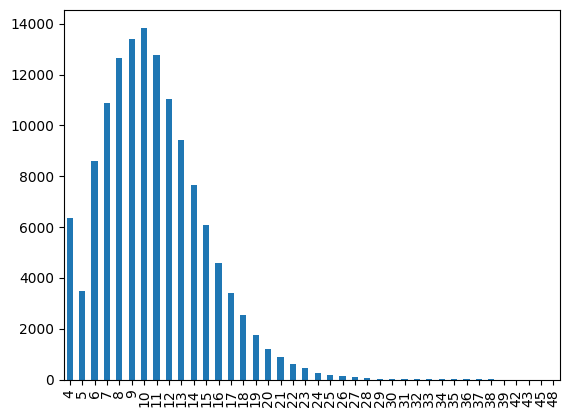

In [91]:
heights = pd.Series(heights).sort_index()
heights.plot(kind='bar')

In [92]:
heights_df = heights.to_frame('n')
heights_df['frac'] = heights_df['n'] / heights.sum()
heights_df['cuml_frac'] = heights_df['frac'].cumsum()
heights_df[heights_df['cuml_frac'] > 0.99].index.min()

np.int64(23)

In [93]:
len(ontn_sentc_tree_prc18)

132609

In [94]:
ontn_sentc_tree_fin = []
for i, sent in enumerate(ontn_sentc_tree_prc18):
    if sent['height'] < 23:
        ontn_sentc_tree_fin.append(sent)

In [95]:
len(ontn_sentc_tree_fin)

131280

# Add levels to non-terminal 

In [96]:
def add_levels(tree: Tree) -> Tree:
    tps = tree.treepositions('leaves')
    for tp in tps:
        branch_height = len(tp)
        tp_list = list(tp)
        for i in range(branch_height):
            idx = tuple(tp_list[:i+1]) 
            if tree[idx].height() == 2:  # if it is (Non-term Term), we don't add level to Non-term
                break
            act_label = tree[idx].label()  # actual label
            if not act_label[-1].isdigit():
                tree[idx].set_label(f"{act_label}_{i}")
    return tree

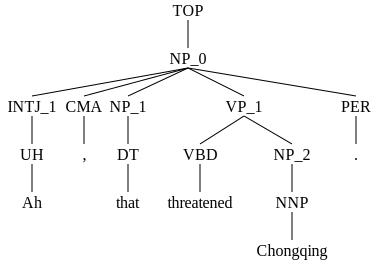

In [97]:
sent = ontn_sentc_tree_fin[15]
tree = Tree.fromstring(sent['parse_tree'])

add_levels(tree)

# Get all productions like a DICT

In [98]:
def process_chunk(chunk: List[Dict]) -> Dict:
    local_dict = {}
    for elem in chunk:
        tree = add_levels(Tree.fromstring(elem['parse_tree']))
        for prod in tree.productions():
            lhs = prod.lhs()
            rhs = prod.rhs()
            if lhs in local_dict:
                if rhs not in local_dict[lhs]:
                    local_dict[lhs].append(rhs)
            else:
                local_dict[lhs] = [rhs]
    return local_dict

def merge_dicts(dict_list: List[Dict]) -> Dict:
    merged = {}
    for local_dict in dict_list:
        for lhs, rhs_list in local_dict.items():
            if lhs not in merged:
                merged[lhs] = []
            existing_rhs = merged[lhs]
            for rhs in rhs_list:
                if rhs not in existing_rhs:
                    existing_rhs.append(rhs)
    return merged

In [99]:
num_processes = multiprocessing.cpu_count()
num_processes

16

In [100]:
total_elements = len(ontn_sentc_tree_fin)
chunk_size = max(1, total_elements // num_processes)
chunks = [ontn_sentc_tree_fin[i:i+chunk_size] for i in range(0, total_elements, chunk_size)]

with multiprocessing.Pool(processes=num_processes) as pool:
    chunk_dicts = pool.map(process_chunk, chunks)

productions_dict = merge_dicts(chunk_dicts)

In [101]:
# productions_dict: Dict[str, Optional[List[str]]] = dict()
# for elem in tqdm(ontn_sentc_tree):
#     tree = Tree.fromstring(elem['parse_tree'])

#     for prod in tree.productions():
#         if prod.lhs() in productions_dict.keys():
#             if prod.rhs() in productions_dict[prod.lhs()]:
#                 pass
#             else:
#                 productions_dict[prod.lhs()].append(prod.rhs())
#         else:
#             productions_dict[prod.lhs()] = [prod.rhs()]

In [102]:
productions_dict.keys()

dict_keys([TOP, SBARQ_0, WHNP_1, WHNP_2, WP, NN, PP_2, IN, NP_3, QM, S_0, NP_1, PRP, ADVP_1, RB, VP_1, VB, NP_2, S_2, VP_3, TO, VP_4, NP_5, NP_6, IAC, JJ, PP_6, NP_7, NNP, PER, SINV_0, VBG, ADJP_3, VBZ, DA, NML_4, NNPS, VP_2, VBN, PP_3, NP_4, CMA, NNS, NML_6, NML_7, CC, PP_5, NP_0, CD, NML_2, VBD, PP_4, JJS, NP_8, PP_8, NP_9, DT, POS, PRT_5, RP, ADVP_6, SBAR_3, WHADVP_4, WRB, S_4, VP_5, VP_6, ADVP_7, PP_1, NML_5, SBAR_2, WHADVP_3, S_3, SBAR_6, S_7, VP_8, ADVP_9, VP_9, NP_10, PP_10, NP_11, NP_12, PP_12, NP_13, IAV, INTJ_1, UH, MD, ADVP_2, INTJ_2, ADJP_2, ADVP_3, PRP_DLR, NML_3, ADJP_6, JJR, PP_7, ADJP_5, SBAR_5, S_6, VP_7, PP_9, S_5, NML_10, HYPH, ADJP_8, PP_11, S_13, VP_14, VP_15, VP_16, ADVP_17, NP_17, S_9, VP_10, S_11, NML_14, VP_12, VP_13, NP_14, INTJ_5, ADJP_4, PRT_7, ADVP_4, RBR, INTJ_0, PDT, INTJ_4, NML_9, NML_8, SQ_1, S_1, WHNP_4, WDT, PRT_2, SQ_0, VBP, PRT_6, WHADVP_1, PRT_3, WHNP_6, SBAR_4, PRT_9, SBAR_9, S_10, VP_11, PRT_8, NML_12, S_15, VP_17, QP_9, SBAR_1, QP_2, ADJP_7, PRT

# Productions dict to grammar

## To JSON

In [103]:
from collections import defaultdict

In [104]:
ALL_RHS = list(productions_dict.keys())
prod_to_json = defaultdict(list)
for lhs in tqdm(ALL_RHS):
    left = str(lhs)
    for i, rhs_tuple in enumerate(productions_dict[lhs]):
        right = ""
        for rhs in rhs_tuple:
            if isinstance(rhs, Nonterminal):
                # prod_to_json[left].append(str(rhs))
                right += str(rhs) + " "
            else:
                prod_to_json[left].append('\"' + rhs + '\"')
        if right != "":
            prod_to_json[left].append(right.strip())

100%|██████████| 522/522 [00:00<00:00, 3241.18it/s]


In [105]:
import json

In [106]:
with open('ontonotesv5_gram.json', 'w') as f:
    json.dump(prod_to_json, f, indent=4)